## Simple Convolutional Neural Network

### Objective

This notebook introduces a simple convolutional neural network (CNN) for the
binary happiness classification task. The model is designed to preserve spatial
structure in facial images and directly address the limitations observed in the
baseline error analysis.

The architecture is intentionally minimal to maintain interpretability.

In [20]:
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

## Import Data Loader

Data is loaded using the same preprocessing pipeline defined earlier.

In [21]:
PROJECT_ROOT = Path("..")
sys.path.insert(0, str(PROJECT_ROOT))

from src.data import load_train_test

## Load Dataset

Images are loaded in their original spatial form without flattening.

In [22]:
DATA_DIR = PROJECT_ROOT / "data"
X_train, y_train, X_test, y_test = load_train_test(DATA_DIR)

X_train.shape, y_train.shape

((28709, 48, 48), (28709,))

## Prepare Data for CNN

CNNs expect an explicit channel dimension. Since images are grayscale,
a single channel is added.

In [23]:
X_train_cnn = X_train[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

X_train_cnn.shape, X_test_cnn.shape

((28709, 48, 48, 1), (7178, 48, 48, 1))

## Define CNN Architecture

The model consists of:
- one convolutional layer for local feature extraction,
- one pooling layer for spatial downsampling,
- one fully connected layer for classification.

This structure directly targets the weaknesses of the baseline model.

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Input

In [25]:
model = Sequential([
    Input(shape=X_train_cnn.shape[1:]),
    Conv2D(
        filters=16,
        kernel_size=(3, 3),
        activation="relu"
    ),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8464)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │       270,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,073 (1.03 MB)

 Trainable params: 271,073 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

## Compile Model

Binary cross-entropy is used as the loss function, consistent with the
binary classification objective.

In [26]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

## Train CNN

The model is trained for a small number of epochs to avoid overfitting and to
keep training behavior interpretable.

In [27]:
history = model.fit(
    X_train_cnn,
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7317 - loss: 0.5414 - val_accuracy: 0.9317 - val_loss: 0.2514
Epoch 2/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7881 - loss: 0.4658 - val_accuracy: 0.8988 - val_loss: 0.2703
Epoch 3/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8143 - loss: 0.4200 - val_accuracy: 0.9251 - val_loss: 0.2334
Epoch 4/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8269 - loss: 0.3958 - val_accuracy: 0.9126 - val_loss: 0.2418
Epoch 5/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8368 - loss: 0.3765 - val_accuracy: 0.9371 - val_loss: 0.1839
Epoch 6/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8421 - loss: 0.3626 - val_accuracy: 0.9228 - val_loss: 0.2004
Epoch 7/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8508 - loss: 0.3462 - val_accuracy: 0.8870 - val_loss: 0.2752
Epoch 8/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8598 - loss: 0.3325 - val_accuracy: 0.

## Evaluate Model

Performance is evaluated on the held-out test set.

In [28]:
test_loss, test_accuracy = model.evaluate(X_test_cnn, y_test, verbose=0)
test_accuracy

0.8326832056045532

## Training Dynamics

Training and validation accuracy are visualized to assess convergence and
potential overfitting.

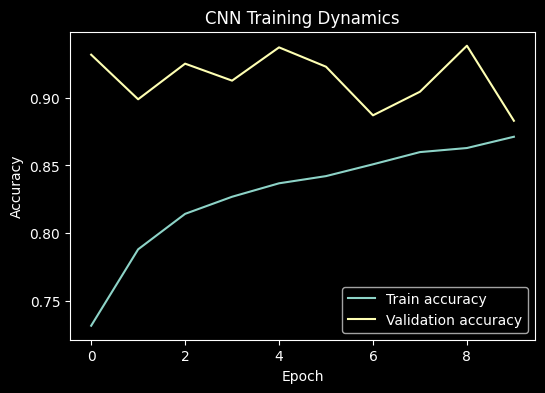

In [29]:
plt.figure(figsize=(6, 4))
plt.plot(history.history["accuracy"], label="Train accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("CNN Training Dynamics")
plt.show()

## Interpretation

- The CNN outperforms the logistic regression baseline, confirming the importance
  of spatial information.
- Even a minimal convolutional architecture captures meaningful facial patterns.
- The improvement aligns with the error patterns observed earlier.

## Stop Condition

This model demonstrates that preserving spatial structure significantly improves
performance. Further gains would require either deeper architectures or more
data, both of which introduce additional complexity.